In [126]:
import os
import numpy as np
import pandas as pd
import importlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sn
import sklearn.model_selection
import sklearn.neighbors
import sklearn.preprocessing
import sklearn.linear_model
import sklearn.tree
import sklearn.datasets
import matplotlib.colors
import logging
import itertools

%matplotlib inline

import mlutil
importlib.reload(mlutil)
mlu = mlutil.MLUtil()
mlu.set_jupyter_defaults()


In [39]:
def get_fruits_data():
    '''
    read fruits data 
    returns: tuple containing 
      X: frame with 4 features (mass, width, height, color_score) and 
      y: target numeric value
      m: dict mapping numeric value to fruit_name (e.g. {1: 'apple', 2: 'orange'})
    '''
    fruits = pd.read_table('data/fruit_data_with_colors.txt')
    X = fruits[['mass', 'width', 'height', 'color_score']]
    y = fruits.fruit_label
    m = fruits.groupby('fruit_label').fruit_name.first().to_dict()
    return X, y, m

def get_friedman1_data(plot=False):
    '''
    Create Synthetic dataset for more complex regression. Plot the values 
    return: tuple (X, y)
    '''
    X_F1, y_F1 = sklearn.datasets.make_friedman1(n_samples=100, n_features=7, random_state=0)
    if plot:
        fig, ax = plt.subplots(figsize=(12,8))
        ax.set_title("Friedman1 Regression with 7 features", fontdict={'fontsize': 24})
        ax.scatter(X_F1[:,6], y_F1, marker='o', s=60)
        ax.set_xlabel('7th Feature')
        ax.set_ylabel('Target')
    return X_F1, y_F1

def get_binary_classification_data(plot=False):
    '''
    Create data set for binary classificaion and plot
    return: tuple (X: 100x2 data, y: targets)
    '''
    cmap_bold = matplotlib.colors.ListedColormap(['red', 'green'])
    X, y = sklearn.datasets.make_classification(n_samples=100, n_features=2, n_redundant=0, 
                                                n_informative=2, n_clusters_per_class=1, 
                                                class_sep=.5, flip_y=.1, random_state=0)
    if plot:
        fig, ax = plt.subplots(figsize=(12,8))
        ax.set_title("Binary classification", fontsize=24)
        ax.scatter(X[:,0], X[:,1], c=y, marker='o', s=60, cmap=cmap_bold, label='Targets')
        ax.set_xlabel('X1')
        ax.set_xlabel('X2')
        ax.legend()
    return X, y

def get_complex_binary_classification_data(plot=False):
    '''
    Create data set for complex binary classificaion, non seperable data and plot
    return: X, y
    '''
    X, y = sklearn.datasets.make_blobs(n_samples=100, n_features=2, centers=8, cluster_std=1.3, random_state=4)
    y = y % 2
    if plot:
        fig, ax = plt.subplots(figsize=(12,8))
        ax.set_title("Complex binary classification", fontsize=24)
        ax.scatter(X[:,0], X[:,1], c=y, marker='o', s=60, cmap=matplotlib.cm.Dark2, label='Target')
        ax.set_xlabel('X1')
        ax.set_xlabel('X2')
        ax.legend()
    return X, y

def get_crime_data():
    '''
    Load Boston crime data set
    '''
    crime = pd.read_table(os.path.join('data', 'CommViolPredUnnormalizedData.txt'), sep=',', na_values='?')
    # remove features with poor coverage or lower relevance, and keep ViolentCrimesPerPop target column
    columns_to_keep = [5, 6] + list(range(11,26)) + list(range(32, 103)) + [145]
    crime = crime.iloc[:,columns_to_keep].dropna()
    X_crime, y_crime = crime.iloc[:,:-1], crime.iloc[:,-1]
    return X_crime, y_crime

def get_breast_cancer_data():
    ''' 
    load breast_cancer and crime data sets
    '''
    X, y = sklearn.datasets.load_breast_cancer(return_X_y=True)
    return X, y


def get_linear_regression_data(plot=False):
    '''
    Synthetic dataset for simple regression  
    '''
    X_R1, y_R1 = sklearn.datasets.make_regression(n_samples=100, n_features=1, n_informative=1, bias=150.0, noise=30, random_state=0)
    if plot:
        fig, ax = plt.subplots(figsize=(12,8))
        ax.set_title("Sample regression with 1 feature", fontsize=24)
        ax.scatter(X_R1, y_R1, marker='o', s=60)
    return X_R1, y_R1

def show_lr(lr, X_train, X_test, y_train, y_test):
    '''
    Display information about a regression model and scoring, non_zero feature counts
    '''
    print(f"Coeff: {lr.coef_}")
    print(f"Intercept: {lr.intercept_}")
    print("R-squared score Train {:.3f} Test {:.3f}".format(lr.score(X_train, y_train), lr.score(X_test, y_test)))    
    print("# of non-zero features: {}".format((lr.coef_ != 0).sum()))


## Nearest Neighbor Classifier with normalization (Fruits data)

In [25]:
X, y, label_to_name_map = get_fruits_data()
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=42)

scaler = sklearn.preprocessing.MinMaxScaler().fit(X_train)
X_train_scaled, X_test_scaled = scaler.transform(X_train), scaler.transform(X_test)

knn_scaled = sklearn.neighbors.KNeighborsClassifier(n_neighbors=5)
knn_scaled.fit(X_train_scaled, y_train)
print(f"Train accuracy for scaled: {knn_scaled.score(X_train_scaled, y_train)}")
print(f"Test  accuracy for scaled: {knn_scaled.score(X_test_scaled, y_test)}")


# add predicted and actual labels
df = pd.DataFrame({'actual': y_test, 'scaled_predicted': knn_scaled.predict(X_test_scaled)})
for c in df.columns:
    df[c+'_n'] = df[c].map(label_to_name_map)
failed = df[df.scaled_predicted != df.actual]

print('Predicted vs Acutal\n')
print(failed)
print ('\n')
# test a specific example
example_fruit = [[68, 6.2, 4.3, 0.8]]
example_fruit_scaled = scaler.transform(example_fruit)
predicted_name = label_to_name_map[knn_scaled.predict(example_fruit_scaled)[0]]
print(f'Predicted fruit type for {example_fruit} is {predicted_name}')

Train accuracy for scaled: 0.9772727272727273
Test  accuracy for scaled: 0.9333333333333333
Predicted vs Acutal

    actual  scaled_predicted actual_n scaled_predicted_n
31       3                 1   orange              apple


Predicted fruit type for [[68, 6.2, 4.3, 0.8]] is mandarin


## K Nearest Neighbors Classification on Binary Data

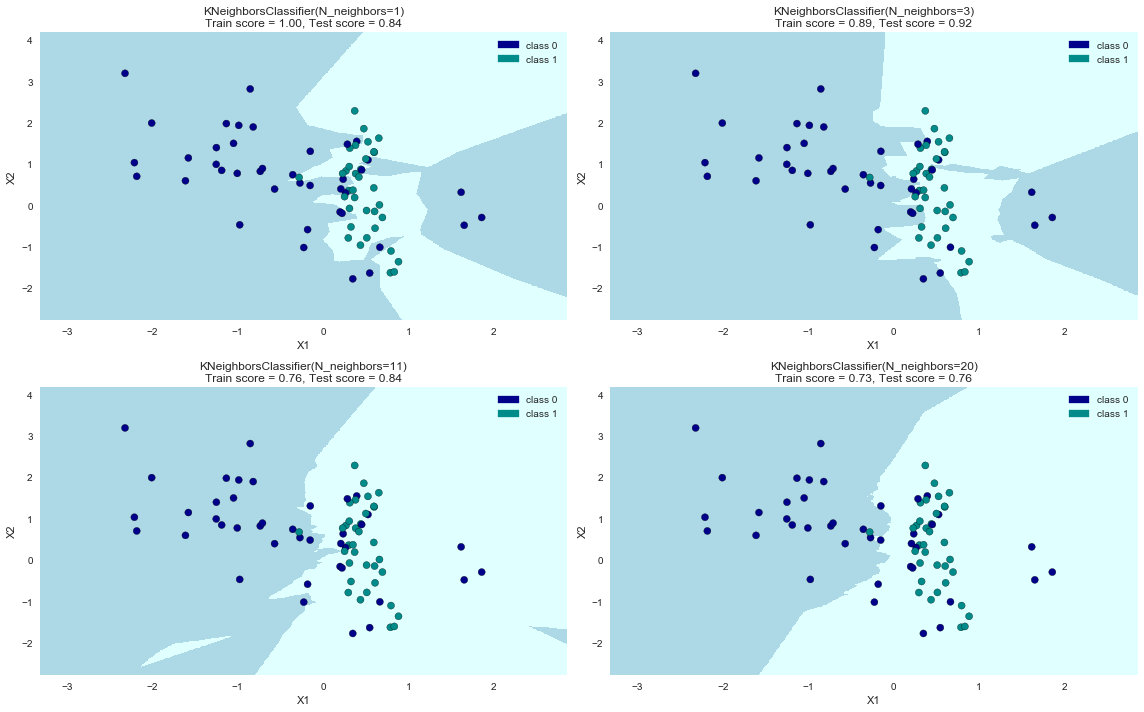

In [32]:
X, y = get_binary_classification_data()
data_sets = sklearn.model_selection.train_test_split(X, y)
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16,10))
for i,k in enumerate([1, 3, 11, 20]):
    ax = axs[i//2][i%2]
    mlu.plot_2class_clf(sklearn.neighbors.KNeighborsClassifier, {'n_neighbors': k}, ax, *data_sets)
plt.tight_layout()

## Regression

R-Squared test score: 0.425


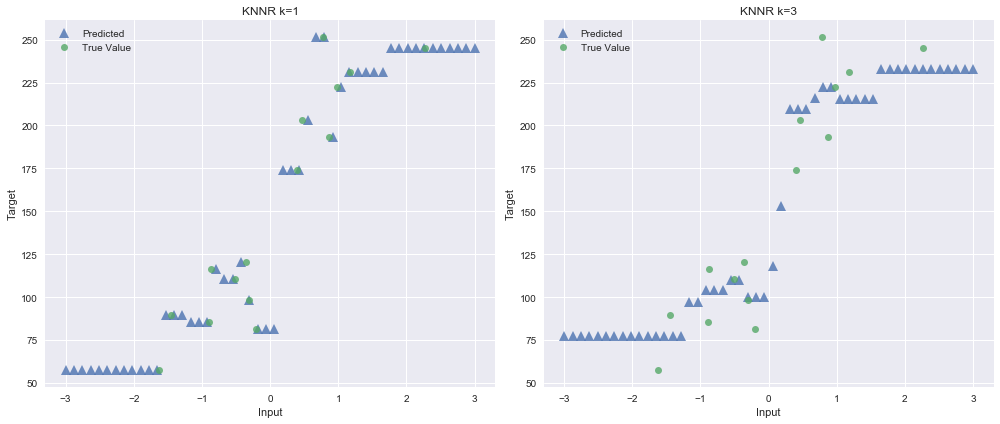

In [10]:
X, y = get_linear_regression_data()
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=0)

knnreg = sklearn.neighbors.KNeighborsRegressor(n_neighbors=5).fit(X_train, y_train)
print('R-Squared test score: {:.3f}'.format(knnreg.score(X_test, y_test)))

xmin, xmax = -3, 3
X_predict_input = np.linspace(xmin, xmax, 50).reshape(-1,1)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X[::5], y[::5], random_state=0)

fig, axs = plt.subplots(1, 2, figsize=(14,6))
for ax, k in zip(axs, [1, 3]):
    knnreg = sklearn.neighbors.KNeighborsRegressor(n_neighbors=k).fit(X_train, y_train)
    y = knnreg.predict(X_predict_input)
    ax.plot(X_predict_input, y, '^', markersize=10, label='Predicted', alpha=.8)
    ax.plot(X_train, y_train, 'o', label='True Value', alpha=.8)
    ax.set_xlabel('Input')
    ax.set_ylabel('Target')
    ax.set_title(f'KNNR k={k}')
    ax.legend()
plt.tight_layout()

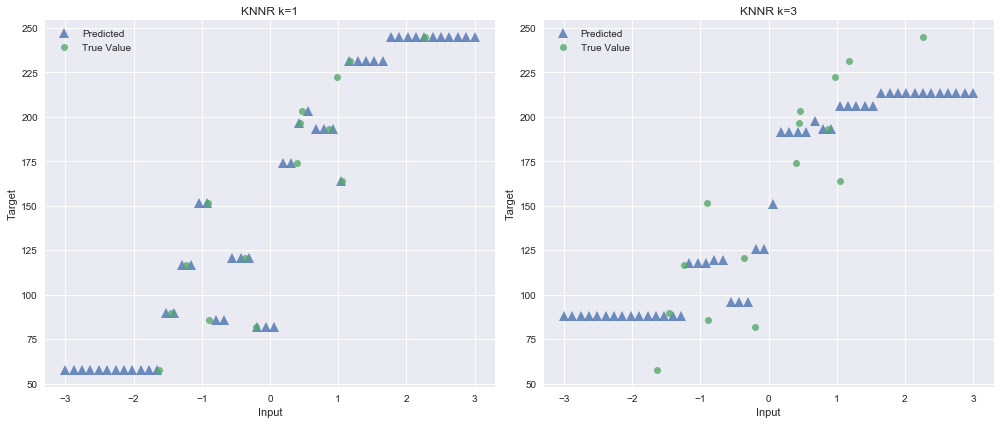

## Regression model complexity as a function of K

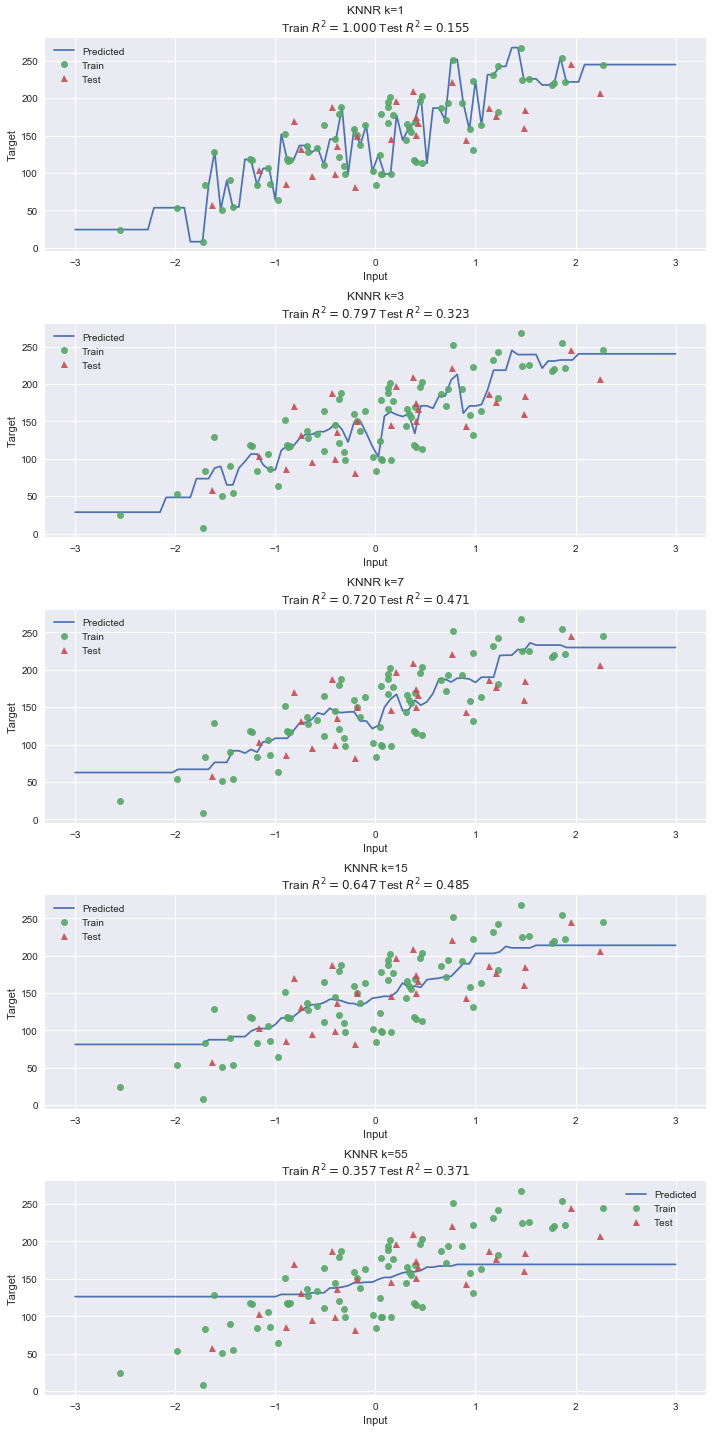

In [13]:
xmin, xmax = -3, 3
X_predict_input = np.linspace(xmin, xmax, 100).reshape(-1,1)
X, y = get_linear_regression_data()
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=0)

klist = [1, 3, 7, 15, 55]
fig, axs = plt.subplots(len(klist), 1, figsize=(10,4*len(klist)))
for ax, k in zip(axs, klist):
    knnreg = sklearn.neighbors.KNeighborsRegressor(n_neighbors=k).fit(X_train, y_train)
    y = knnreg.predict(X_predict_input)
    train_score = knnreg.score(X_train, y_train)
    test_score = knnreg.score(X_test, y_test)
    ax.plot(X_predict_input, y, label='Predicted')
    ax.plot(X_train, y_train, 'o', label='Train', alpha=.9)
    ax.plot(X_test, y_test, '^', label='Test', alpha=.9)
    ax.set_xlabel('Input')
    ax.set_ylabel('Target')
    ax.set_title(f'KNNR k={k}\nTrain $R^2={train_score:.3f}$ Test $R^2={test_score:.3f}$')
    ax.legend()
plt.tight_layout()

## Linear models for Regression

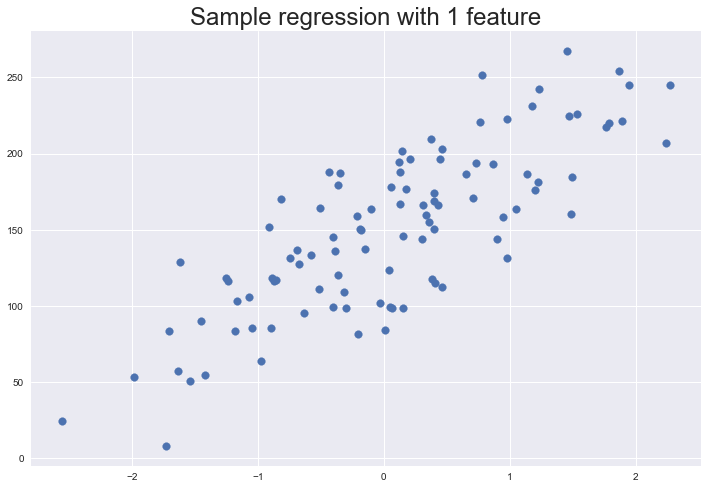

In [14]:
X, y = get_linear_regression_data(plot=True)

Coeff: [ 45.71]
Intercept: 148.44575345658873
R-squared score Train 0.679 Test 0.492
# of non-zero features: 1


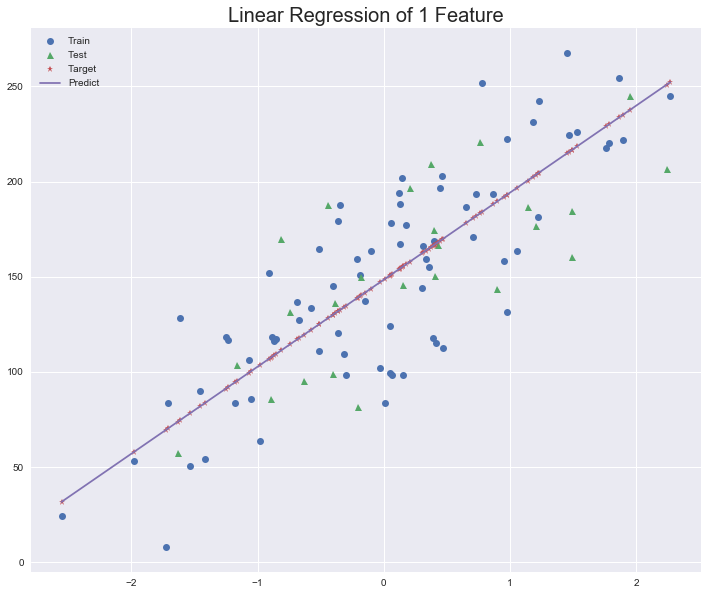

In [18]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=0)
lr = sklearn.linear_model.LinearRegression().fit(X_train, y_train)
show_lr(lr, X_train, X_test, y_train, y_test)

fig, ax = plt.subplots(figsize=(12,10))
X_predict = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
ax.plot(X_train, y_train, 'o', label='Train')
ax.plot(X_test, y_test, '^', label='Test')
ax.plot(X, lr.predict(X), '*', label='Target')
ax.plot(X_predict, lr.predict(X_predict), label='Predict')
ax.set_title('Linear Regression of 1 Feature', fontdict={'fontsize': 20})
ax.legend()

In [19]:
X, y = get_crime_data()
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=0)
lr = sklearn.linear_model.LinearRegression().fit(X_train, y_train)
show_lr(lr, X_train, X_test, y_train, y_test)

Coeff: [  1.62e-03  -9.43e+01   1.36e+01  -3.13e+01  -8.15e-02  -1.69e+01
  -2.43e-03   1.53e+00  -1.39e-02  -7.72e+00   2.28e+01  -5.66e+00
   9.35e+00   2.07e-01  -7.43e+00   9.66e-03   4.38e-03   4.80e-03
  -4.46e+00  -1.61e+01   8.83e+00  -5.07e-01  -1.42e+00   8.18e+00
  -3.87e+00  -3.54e+00   4.49e+00   9.31e+00   1.74e+02   1.18e+01
   1.51e+02  -3.30e+02  -1.35e+02   6.95e-01  -2.38e+01   2.77e+00
   3.82e-01   4.39e+00  -1.06e+01  -4.92e-03   4.14e+01  -1.16e-03
   1.19e+00   1.75e+00  -3.68e+00   1.60e+00  -8.42e+00  -3.80e+01
   4.74e+01  -2.51e+01  -2.88e-01  -3.66e+01   1.90e+01  -4.53e+01
   6.83e+02   1.04e+02  -3.29e+02  -3.14e+01   2.74e+01   5.12e+00
   6.92e+01   1.98e-02  -6.12e-01   2.65e+01   1.01e+01  -1.59e+00
   2.24e+00   7.38e+00  -3.14e+01  -9.78e-05   5.02e-05  -3.48e-04
  -2.50e-04  -5.27e-01  -5.17e-01  -4.10e-01   1.16e-01   1.46e+00
  -3.04e-01   2.44e+00  -3.66e+01   1.41e-01   2.89e-01   1.77e+01
   5.97e-01   1.98e+00  -1.36e-01  -1.85e+00]
Intercept

## Ridge

In [21]:
X, y = get_crime_data()
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=0)
lr = sklearn.linear_model.Ridge(alpha=20).fit(X_train, y_train)
show_lr(lr, X_train, X_test, y_train, y_test)

Coeff: [  1.95e-03   2.19e+01   9.56e+00  -3.59e+01   6.36e+00  -1.97e+01
  -2.81e-03   1.66e+00  -6.61e-03  -6.95e+00   1.72e+01  -5.63e+00
   8.84e+00   6.79e-01  -7.34e+00   6.70e-03   9.79e-04   5.01e-03
  -4.90e+00  -1.79e+01   9.18e+00  -1.24e+00   1.22e+00   1.03e+01
  -3.78e+00  -3.73e+00   4.75e+00   8.43e+00   3.09e+01   1.19e+01
  -2.05e+00  -3.82e+01   1.85e+01   1.53e+00  -2.20e+01   2.46e+00
   3.29e-01   4.02e+00  -1.13e+01  -4.70e-03   4.27e+01  -1.23e-03
   1.41e+00   9.35e-01  -3.00e+00   1.12e+00  -1.82e+01  -1.55e+01
   2.42e+01  -1.32e+01  -4.20e-01  -3.60e+01   1.30e+01  -2.81e+01
   4.39e+01   3.87e+01  -6.46e+01  -1.64e+01   2.90e+01   4.15e+00
   5.34e+01   1.99e-02  -5.47e-01   1.24e+01   1.04e+01  -1.57e+00
   3.16e+00   8.78e+00  -2.95e+01  -2.33e-04   3.14e-04  -4.13e-04
  -1.80e-04  -5.74e-01  -5.18e-01  -4.21e-01   1.53e-01   1.33e+00
   3.85e+00   3.03e+00  -3.78e+01   1.38e-01   3.08e-01   1.57e+01
   3.31e-01   3.36e+00   1.61e-01  -2.68e+00]
Intercept

Alpha = 1 Large Coeffs: 60 Train: 0.673 Test: 0.497
Alpha = 10 Large Coeffs: 63 Train: 0.671 Test: 0.495
Alpha = 20 Large Coeffs: 62 Train: 0.671 Test: 0.494
Alpha = 50 Large Coeffs: 62 Train: 0.670 Test: 0.493
Alpha = 100 Large Coeffs: 60 Train: 0.670 Test: 0.491
Alpha = 200 Large Coeffs: 61 Train: 0.669 Test: 0.488
Alpha = 1000 Large Coeffs: 57 Train: 0.665 Test: 0.464


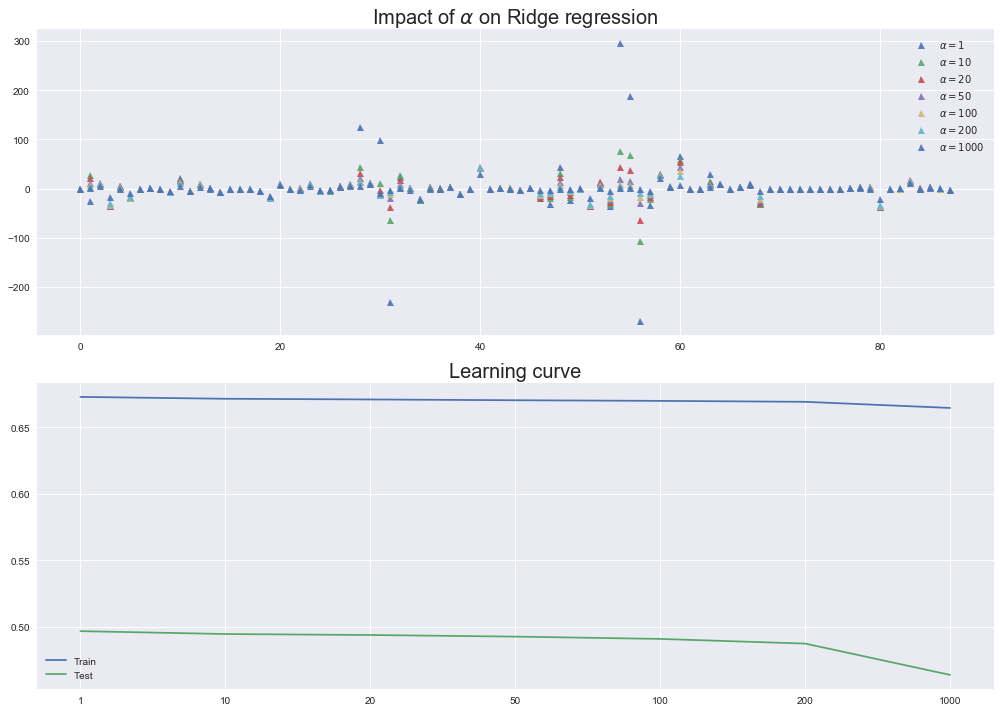

In [22]:
# impact of alpha on coefficients (weights) 

X, y = get_crime_data()
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=0)
alpha_values = [1, 10, 20, 50, 100, 200, 1000]
fig, (ax, ax2) = plt.subplots(nrows=2, figsize=(14,10))

train_scores, test_scores = [], []
for alpha in alpha_values:
    lr = sklearn.linear_model.Ridge(alpha=alpha).fit(X_train, y_train)
    ax.plot(lr.coef_, '^', label=rf'$\alpha = {alpha}$', alpha=.9)
    train_score, test_score = lr.score(X_train, y_train), lr.score(X_test, y_test)
    large_coeffs = np.sum(np.abs(lr.coef_) > 1)
    print(f'Alpha = {alpha} Large Coeffs: {large_coeffs} Train: {train_score:.3f} Test: {test_score:.3f}')
    train_scores.append(train_score)
    test_scores.append(test_score)
ax.legend()

ax.set_title(rf'Impact of $\alpha$ on Ridge regression', fontdict={'fontsize': 20})
#for i, (alpha, (trn, tst)) in enumerate(zip(alpha_values, lc)):
ax2.plot(train_scores, label='Train')
ax2.plot(test_scores, label='Test')
ax2.set_title('Learning curve', fontdict={'fontsize': 20})
ax2.legend()
ax2.set_xticks(range(len(alpha_values)))
ax2.set_xticklabels([rf"{a}" for a in alpha_values])
plt.tight_layout()


## Ridge with normalization

In [24]:
X, y = get_crime_data()
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=0)
scaler = sklearn.preprocessing.MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)
lr = sklearn.linear_model.Ridge(alpha=20).fit(X_train_norm, y_train)
show_lr(lr, X_train_norm, X_test_norm, y_train, y_test)

Coeff: [  88.69   16.49  -50.3   -82.91  -65.9    -2.28   87.74  150.95   18.88
  -31.06  -43.14 -189.44   -4.53  107.98  -76.53    2.86   34.95   90.14
   52.46  -62.11  115.02    2.67    6.94   -5.67 -101.55  -36.91   -8.71
   29.12  171.26   99.37   75.07  123.64   95.24 -330.61 -442.3  -284.5
 -258.37   17.66 -101.71  110.65  523.14   24.82    4.87  -30.47   -3.52
   50.58   10.85   18.28   44.11   58.34   67.09  -57.94  116.14   53.81
   49.02   -7.62   55.14  -52.09  123.39   77.13   45.5   184.91  -91.36
    1.08  234.09   10.39   94.72  167.92  -25.14   -1.18   14.6    36.77
   53.2   -78.86   -5.9    26.05  115.15   68.74   68.29   16.53  -97.91
  205.2    75.97   61.38  -79.83   67.27   95.67  -11.88]
Intercept: 933.3906385044161
R-squared score Train 0.615 Test 0.599
# of non-zero features: 88


## Lasso regression

Alpha = 0.5 NonZero Coeffs: 35 Train: 0.650 Test: 0.581
Alpha = 1 NonZero Coeffs: 25 Train: 0.641 Test: 0.605
Alpha = 2 NonZero Coeffs: 20 Train: 0.631 Test: 0.624
Alpha = 3 NonZero Coeffs: 17 Train: 0.618 Test: 0.627
Alpha = 4 NonZero Coeffs: 14 Train: 0.607 Test: 0.620
Alpha = 5 NonZero Coeffs: 12 Train: 0.601 Test: 0.614
Alpha = 10 NonZero Coeffs: 6 Train: 0.567 Test: 0.578
Alpha = 20 NonZero Coeffs: 2 Train: 0.509 Test: 0.504
Alpha = 50 NonZero Coeffs: 1 Train: 0.313 Test: 0.302


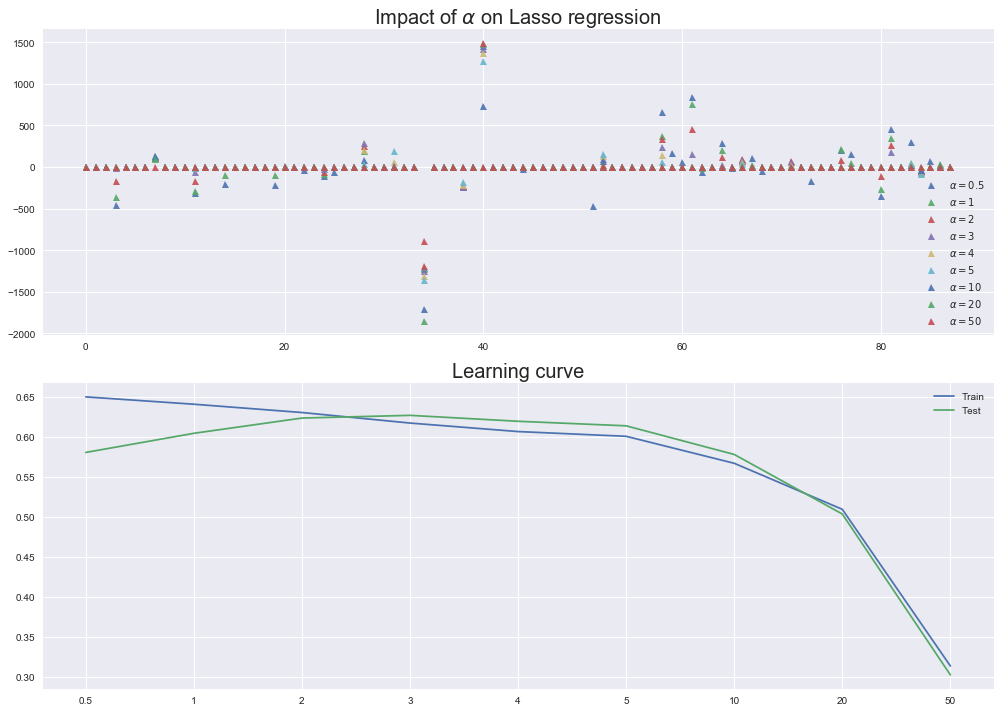

In [25]:
X, y = get_crime_data()
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=0)
scaler = sklearn.preprocessing.MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

alpha_values = [.5, 1, 2, 3, 4, 5, 10, 20, 50]
fig, (ax, ax2) = plt.subplots(nrows=2, figsize=(14,10))

train_scores, test_scores = [], []
for alpha in alpha_values:
    lr = sklearn.linear_model.Lasso(alpha=alpha).fit(X_train_scaled, y_train)
    ax.plot(lr.coef_, '^', label=rf'$\alpha = {alpha}$', alpha=.9)
    train_score, test_score = lr.score(X_train_scaled, y_train), lr.score(X_test_scaled, y_test)
    coeffs_count = np.sum(lr.coef_ != 0)
    print(f'Alpha = {alpha} NonZero Coeffs: {coeffs_count} Train: {train_score:.3f} Test: {test_score:.3f}')
    train_scores.append(train_score)
    test_scores.append(test_score)
ax.legend()
ax.set_title('Lasso Regression', fontdict={'fontsize': 20})

ax.set_title(rf'Impact of $\alpha$ on Lasso regression', fontdict={'fontsize': 20})
#for i, (alpha, (trn, tst)) in enumerate(zip(alpha_values, lc)):
ax2.plot(train_scores, label='Train')
ax2.plot(test_scores, label='Test')
ax2.set_title('Learning curve', fontdict={'fontsize': 20})
ax2.legend()
ax2.set_xticks(range(len(alpha_values)))
ax2.set_xticklabels([rf"{a}" for a in alpha_values])
plt.tight_layout()

## Polynominal Regression

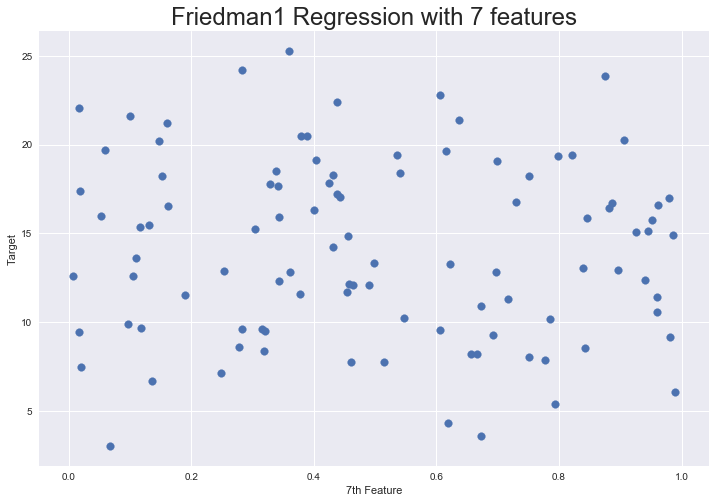

In [28]:
X, y = get_friedman1_data(plot=True)

In [30]:
X, y = get_friedman1_data()
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=0)
lr = sklearn.linear_model.LinearRegression().fit(X_train, y_train)
show_lr(lr, X_train, X_test, y_train, y_test)

Coeff: [  4.42   6.     0.53  10.24   6.55  -2.02  -0.32]
Intercept: 1.542509197537301
R-squared score Train 0.722 Test 0.722
# of non-zero features: 7


In [31]:
# with Poly degree 2
X, y = get_friedman1_data()
poly = sklearn.preprocessing.PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_poly, y, random_state=0)
lr = sklearn.linear_model.LinearRegression().fit(X_train, y_train)
show_lr(lr, X_train, X_test, y_train, y_test)

Coeff: [  3.41e-12   1.66e+01   2.67e+01  -2.21e+01   1.24e+01   6.93e+00
   1.05e+00   3.71e+00  -1.34e+01  -5.73e+00   1.62e+00   3.66e+00
   5.05e+00  -1.46e+00   1.95e+00  -1.51e+01   4.87e+00  -2.97e+00
  -7.78e+00   5.15e+00  -4.65e+00   1.84e+01  -2.22e+00   2.17e+00
  -1.28e+00   1.88e+00   1.53e-01   5.62e-01  -8.92e-01  -2.18e+00
   1.38e+00  -4.90e+00  -2.24e+00   1.38e+00  -5.52e-01  -1.09e+00]
Intercept: -3.205674398929135
R-squared score Train 0.969 Test 0.805
# of non-zero features: 36


Coeff: [  0.     7.47  15.27 -12.24   7.52   3.78  -1.24   1.42  -7.53  -0.09
   2.38   4.37   4.72   0.23  -2.66  -8.16   2.06  -1.7   -3.79   4.9
  -3.52  11.14  -2.46   1.46  -3.83   3.29   3.17   1.3   -0.31  -1.93
   1.84  -4.58   0.41   1.71   4.03  -1.59]
Intercept: 1.9523861040272887
R-squared score Train 0.942 Test 0.844
# of non-zero features: 35


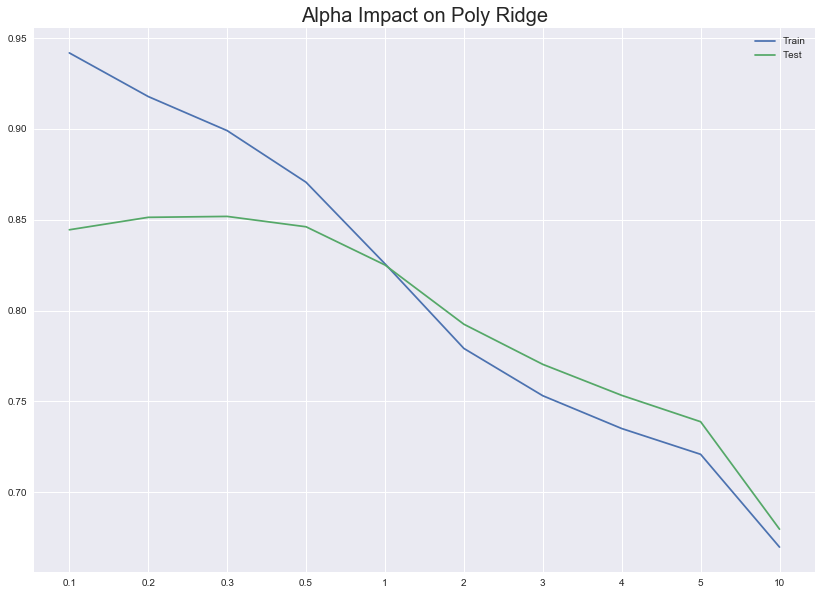

In [34]:
# with Poly degree 2 - using Ridge
X, y = get_friedman1_data()
poly = sklearn.preprocessing.PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_poly, y, random_state=0)
lr = sklearn.linear_model.Ridge(alpha=.1).fit(X_train, y_train)
show_lr(lr, X_train, X_test, y_train, y_test)

train_scores, test_scores = [], []
alpha_values = [.1, .2, .3, .5, 1, 2, 3, 4, 5, 10]
fig, ax2 = plt.subplots(figsize=(14,10))

for alpha in alpha_values:
    lr = sklearn.linear_model.Ridge(alpha=alpha).fit(X_train, y_train)    
    train_scores.append(lr.score(X_train, y_train))
    test_scores.append(lr.score(X_test, y_test))

ax2.plot(train_scores, label='Train')
ax2.plot(test_scores, label='Test')
ax2.set_title('Alpha Impact on Poly Ridge', fontdict={'fontsize': 20})
ax2.legend()
ax2.set_xticks(range(len(alpha_values)))
ax2.set_xticklabels([rf"{a}" for a in alpha_values]);

## Linear models for classification

### Logistic regresssion

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

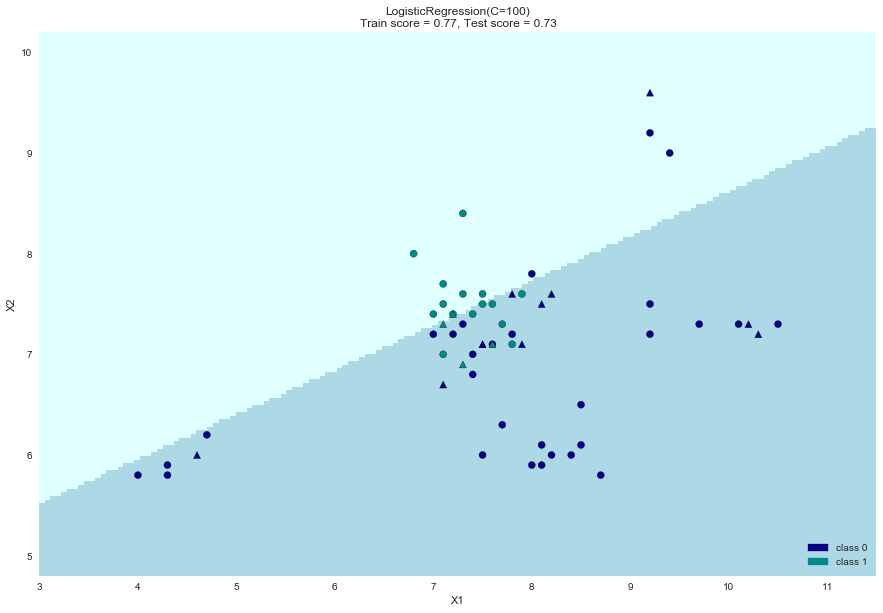

In [50]:
X, y, label_to_name_map = get_fruits_data()
decision_vars = ['height', 'width']
# make it into binary 
y_apple = y == 1
X_2d = X[decision_vars]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_2d, y_apple, random_state=0)
fig, ax = plt.subplots(figsize=(15,10))
mlu.plot_2class_clf(sklearn.linear_model.LogisticRegression, {'C': 100}, ax, 
                    X_train.as_matrix(), X_test.as_matrix(), y_train, y_test)

In [51]:
clf = sklearn.linear_model.LogisticRegression(C=100).fit(X_train, y_train)
dmap = {True: 'is apple', False: 'is not an apple'}
h, w = 7, 9
print(f'Fruit h={h}, w={w} {dmap[clf.predict([[h, w]])[0]]}')
h, w = 7, 6
print(f'Fruit h={h}, w={w} {dmap[clf.predict([[h, w]])[0]]}')

Fruit h=7, w=9 is apple
Fruit h=7, w=6 is not an apple


In [52]:
print('Logistic Train accuracy: {}'.format(clf.score(X_train, y_train)))
print('Logistic Test accuracy: {}'.format(clf.score(X_test, y_test)))

Logistic Train accuracy: 0.7727272727272727
Logistic Test accuracy: 0.7333333333333333


## Logistic regression on simple data

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

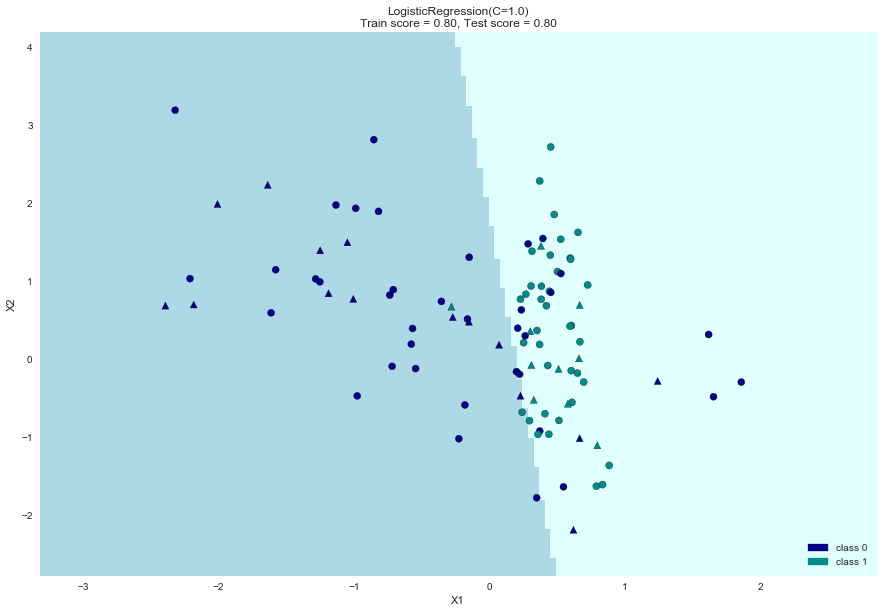

In [57]:
X, y = get_binary_classification_data()
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=0)
fig, ax = plt.subplots(figsize=(15,10))
mlu.plot_2class_clf(sklearn.linear_model.LogisticRegression, {'C': 1.0}, ax, 
                    X_train, X_test, y_train, y_test)

## logistic regression regularization: C Parameter

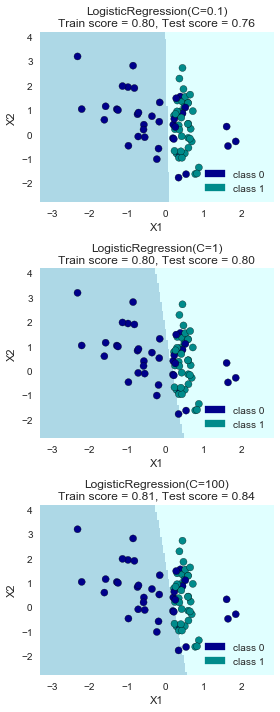

In [62]:
X, y = get_binary_classification_data()
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=0)
fig, axs = plt.subplots(3, 1, figsize=(4,10))
for C, ax in zip([0.1, 1, 100], axs):
    mlu.plot_2class_clf(sklearn.linear_model.LogisticRegression, {'C': C}, ax, 
                    X_train, X_test, y_train, y_test)
plt.tight_layout()

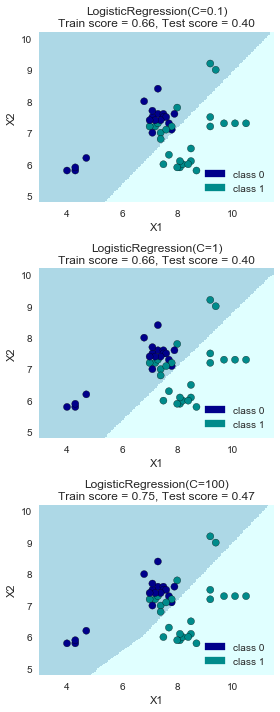

In [71]:
X, y, lblmap = get_fruits_data()
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X[['height', 'width']], y, random_state=0)
fig, axs = plt.subplots(3, 1, figsize=(4,10))
for C, ax in zip([0.1, 1, 100], axs):
    mlu.plot_2class_clf(sklearn.linear_model.LogisticRegression, {'C': C}, ax, 
                    X_train, X_test, y_train, y_test)
plt.tight_layout()

## Application to real data

In [86]:
def test_model_on_breast_cancer_data(model):
    X, y = get_breast_cancer_data()
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=0)
    for C in [0.1, 1, 10, 100, 250]:
        clf = model(C=C).fit(X_train, y_train)
        print(f'Breast cancer Logistic regresion with C = {C}')
        print("Train Accurary: {}".format(clf.score(X_train, y_train)))
        print("Test Accurary: {}".format(clf.score(X_test, y_test)))

test_model_on_breast_cancer_data(sklearn.linear_model.LogisticRegression)


Breast cancer Logistic regresion with C = 0.1
Train Accurary: 0.9507042253521126
Test Accurary: 0.9440559440559441
Breast cancer Logistic regresion with C = 1
Train Accurary: 0.960093896713615
Test Accurary: 0.958041958041958
Breast cancer Logistic regresion with C = 10
Train Accurary: 0.9624413145539906
Test Accurary: 0.951048951048951
Breast cancer Logistic regresion with C = 100
Train Accurary: 0.971830985915493
Test Accurary: 0.958041958041958
Breast cancer Logistic regresion with C = 250
Train Accurary: 0.9694835680751174
Test Accurary: 0.965034965034965


## Support Vector Machines

### Linear support vector machine

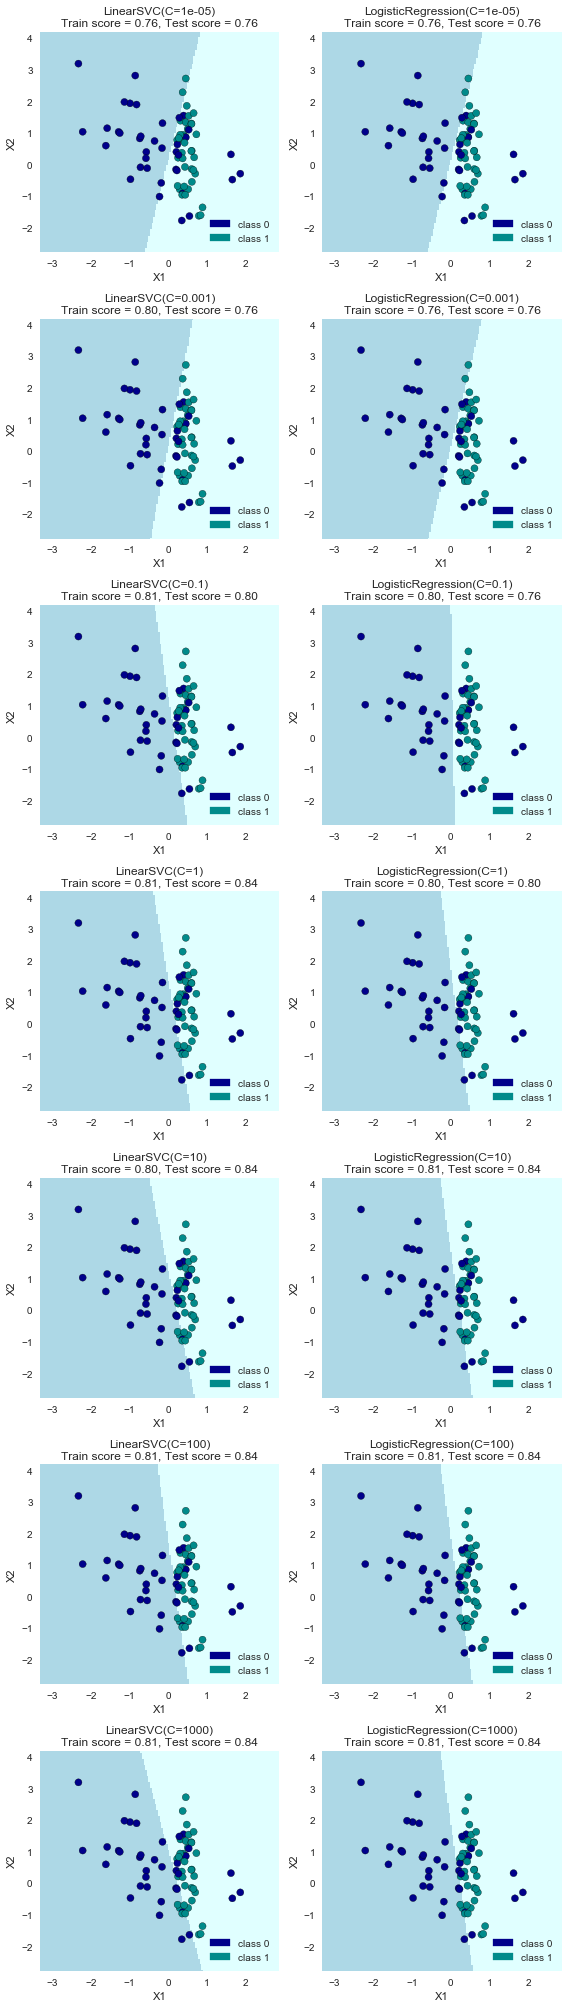

In [85]:
X, y = get_binary_classification_data()
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=0)
Cs = [0.00001, 0.001, 0.1, 1, 10, 100, 1000]
models = [sklearn.svm.LinearSVC, sklearn.linear_model.LogisticRegression]

nrows=len(Cs)
ncols=len(models)
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4))
for row,C in enumerate(Cs):
    for col,model in enumerate(models):
        mlu.plot_2class_clf(model, {'C': C}, axs[row][col], X_train, X_test, y_train, y_test)
plt.tight_layout()

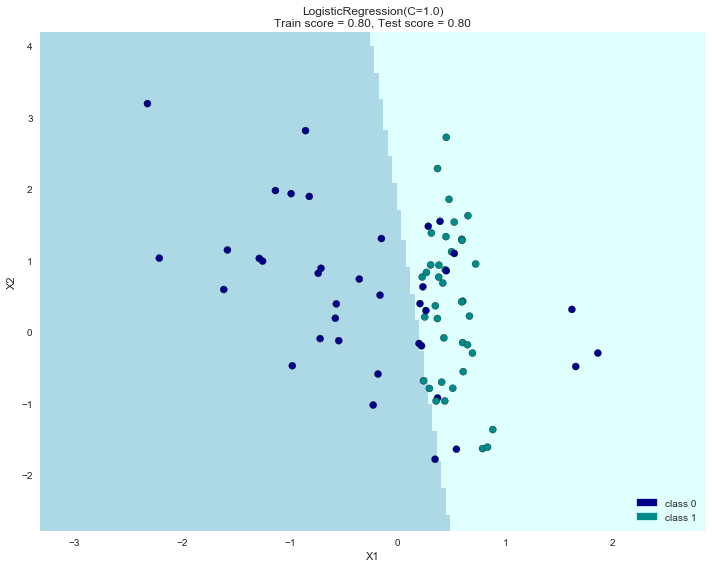

In [82]:
X, y = get_binary_classification_data()
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=0)
fig, ax = plt.subplots(figsize=(10,8))
md = {'C': 1.0}
mlu.plot_2class_clf(sklearn.linear_model.LogisticRegression, md, ax, X_train, X_test, y_train, y_test)
plt.tight_layout()

In [87]:
test_model_on_breast_cancer_data(sklearn.svm.LinearSVC)


Breast cancer Logistic regresion with C = 0.1
Train Accurary: 0.8943661971830986
Test Accurary: 0.8741258741258742
Breast cancer Logistic regresion with C = 1
Train Accurary: 0.8755868544600939
Test Accurary: 0.8601398601398601
Breast cancer Logistic regresion with C = 10
Train Accurary: 0.9225352112676056
Test Accurary: 0.9230769230769231
Breast cancer Logistic regresion with C = 100
Train Accurary: 0.9084507042253521
Test Accurary: 0.9440559440559441
Breast cancer Logistic regresion with C = 250
Train Accurary: 0.9084507042253521
Test Accurary: 0.9440559440559441


### Multi-class classification with linear models

#### Linear SVC with M classes - M one vs rest classifiers

In [12]:
X, y, lblmap = get_fruits_data()
X = X[['width', 'height']]
print(X.shape, lblmap)
print ('Num classes: ', len(lblmap))

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=0)
clf = sklearn.svm.LinearSVC(C=5, random_state=67).fit(X_train, y_train)
print('Coefficients: \n', clf.coef_)
print('Intercepts: \n', clf.intercept_)

(59, 2) {1: 'apple', 2: 'mandarin', 3: 'orange', 4: 'lemon'}
Num classes:  4
Coefficients: 
 [[ 0.72 -0.23]
 [ 1.15 -1.63]
 [ 0.31  0.08]
 [-1.68  1.26]]
Intercepts: 
 [-3.32  1.2  -2.75  1.16]


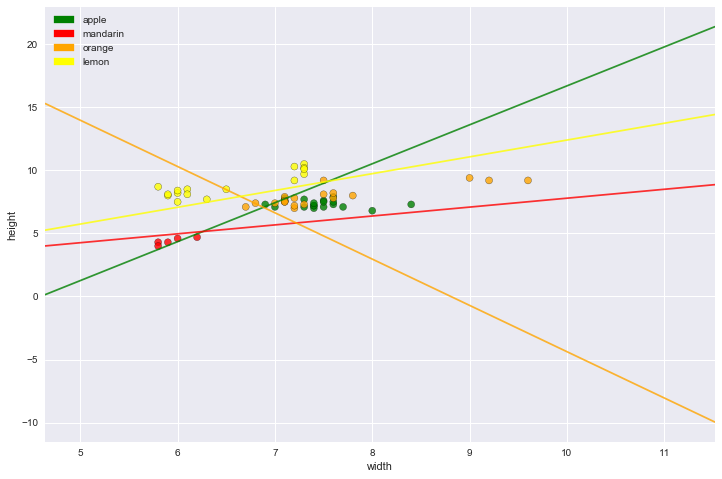

In [38]:
cmap_fruits = mpl.colors.ListedColormap(['green', 'red', 'orange', 'yellow'])

x_min, x_max = X.iloc[:, 0].min()*.8, X.iloc[:, 0].max()*1.2
xr = np.linspace(x_min, x_max, 100)

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(X.width, X.height, c=y, cmap=cmap_fruits, edgecolor='black', alpha=.8)
hdls = []
for k, v in lblmap.items():
    hdls.append(mpl.patches.Patch(color=cmap_fruits.colors[k-1], label=v))

ax.legend(handles=hdls)
ax.set_xlabel(X.columns[0])
ax.set_ylabel(X.columns[1])
ax.set_xlim(x_min, x_max)
# plot classifier lines for each classifier - w1*x1 + w2*x2 + b = 0 

for w, b, c in zip(clf.coef_, clf.intercept_, cmap_fruits.colors):
    yr = -(w[0]*xr + b)/w[1]
    ax.plot(xr, yr, c=c, alpha=.8)

## Kernelized Support Vector Machines

### Classification

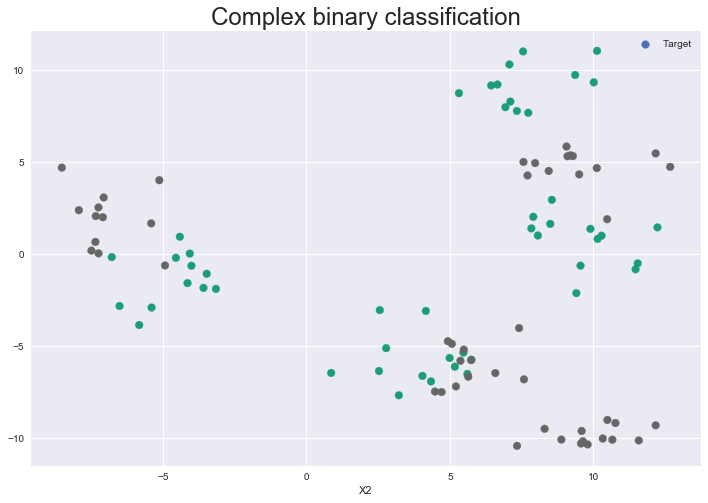

In [44]:
X, y = get_complex_binary_classification_data(plot=True)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=0)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

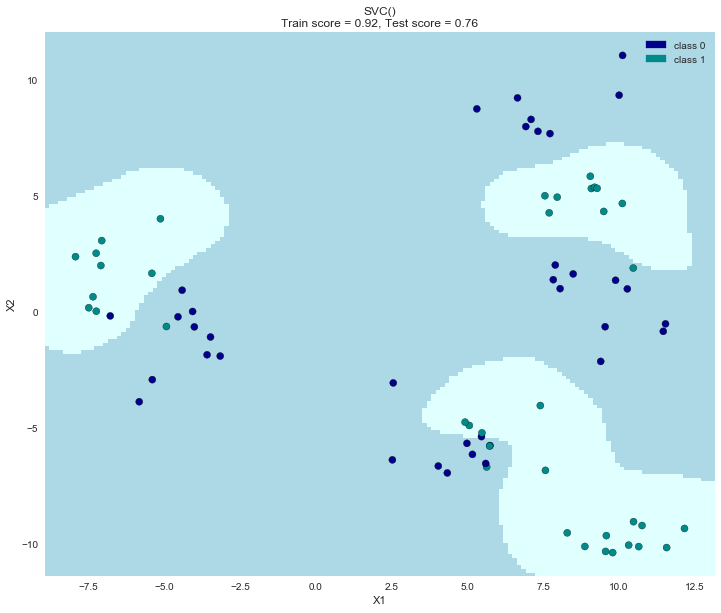

In [51]:
fig, ax = plt.subplots(figsize=(12,10))
mlu.plot_2class_clf(sklearn.svm.SVC, {}, ax, X_train, X_test, y_train, y_test)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

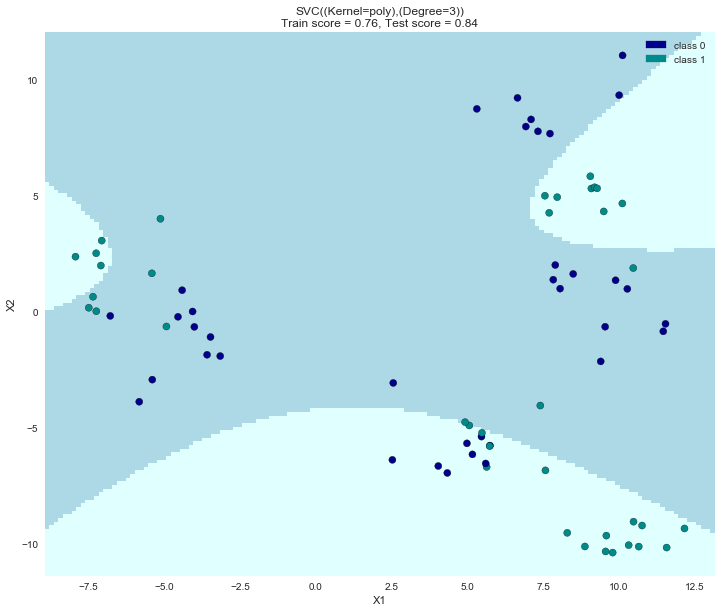

In [52]:
fig, ax = plt.subplots(figsize=(12,10))
mlu.plot_2class_clf(sklearn.svm.SVC, {'kernel':'poly', 'degree':3}, ax, X_train, X_test, y_train, y_test)

#### SVM with RBF Kernel with gamma

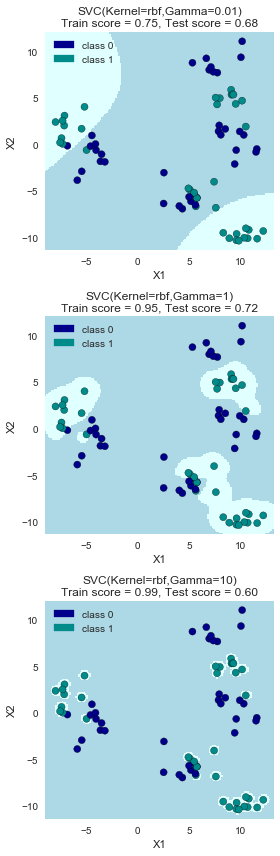

In [56]:
fig, axs = plt.subplots(3, 1, figsize=(4,12))
for gamma, ax in zip([.01, 1, 10], axs):
    mlu.plot_2class_clf(sklearn.svm.SVC, {'kernel':'rbf', 'gamma':gamma}, ax, X_train, X_test, y_train, y_test)
plt.tight_layout()    

#### SVM with RBF Kernel with C and gamma

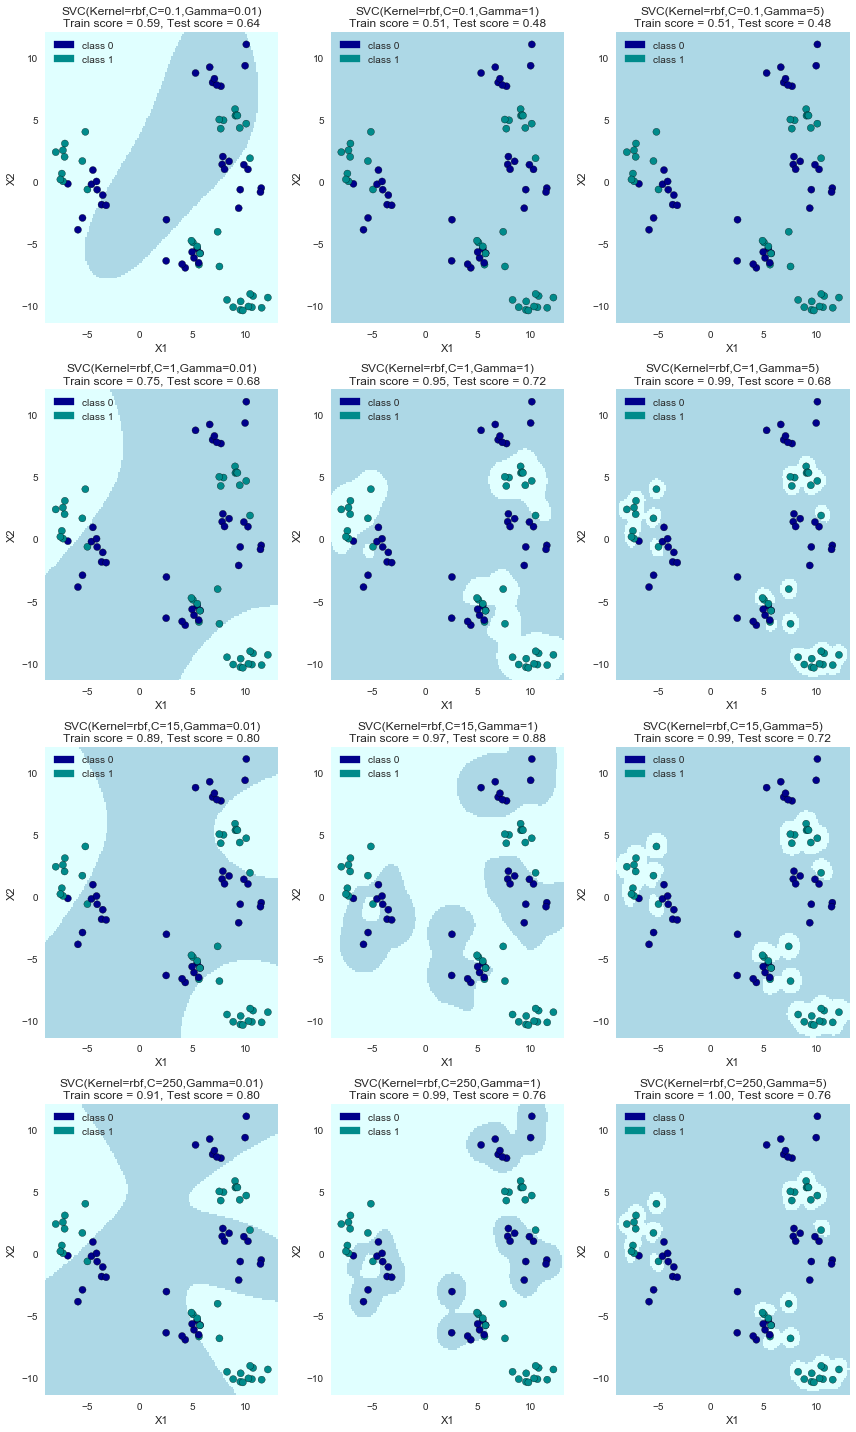

In [59]:
Cs = [.1, 1, 15, 250]
Gammas = [.01, 1, 5]
fig, axs = plt.subplots(len(Cs), len(Gammas), figsize=(len(Gammas)*4, len(Cs)*5))
for row, C in enumerate(Cs):
    for col, gamma in enumerate(Gammas):
        clf_dict = {'kernel':'rbf', 'C':C, 'gamma':gamma}
        mlu.plot_2class_clf(sklearn.svm.SVC, clf_dict, axs[row][col], X_train, X_test, y_train, y_test)
plt.tight_layout()        

#### SVM on real dataset: unnormalized

In [62]:
X, y = get_breast_cancer_data()
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=0)
clf = sklearn.svm.SVC(C=10).fit(X_train, y_train)
print('Cancerdata: SVM With RBF Kernel')
print('Train Accuracy: ', clf.score(X_train, y_train))
print('Test Accuracy: ', clf.score(X_test, y_test))

Cancerdata: SVM With RBF Kernel
Train Accuracy:  1.0
Test Accuracy:  0.629370629371


#### SVM on real dataset: normalized

In [66]:
scaler = sklearn.preprocessing.MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

clf = sklearn.svm.SVC(C=10).fit(X_train_norm, y_train)
print('Cancerdata: SVM With RBF Kernel')
print('Train Accuracy: ', clf.score(X_train_norm, y_train))
print('Test Accuracy: ', clf.score(X_test_norm, y_test))

Cancerdata: SVM With RBF Kernel
Train Accuracy:  0.976525821596
Test Accuracy:  0.958041958042


## Cross Validation

#### K-NN Classifer Cross Validation

In [68]:
X, y, _ = get_fruits_data()
X = X[['width', 'height']]
for k in [1, 5, 10, 15]:
    clf = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k)
    cv_scores = sklearn.model_selection.cross_val_score(clf, X, y)
    print('K = ', k)
    print('Cross Val scores (3-fold): ', cv_scores)
    print('Mean Cross Val: ', np.mean(cv_scores))

K =  1
Cross Val scores (3-fold):  [ 0.82  0.68  0.67]
Mean Cross Val:  0.723019670388
K =  5
Cross Val scores (3-fold):  [ 0.77  0.74  0.83]
Mean Cross Val:  0.780967570441
K =  10
Cross Val scores (3-fold):  [ 0.5   0.58  0.72]
Mean Cross Val:  0.600389863548
K =  15
Cross Val scores (3-fold):  [ 0.55  0.42  0.44]
Mean Cross Val:  0.470317207159


### Validation curve

In [70]:
X, y, _ = get_fruits_data()
X = X[['width', 'height']]
gamma_range = np.logspace(-3, 3, 4)
print(gamma_range)
train_scores, test_scores = sklearn.model_selection.validation_curve(sklearn.svm.SVC(), X, y, param_name='gamma', 
                                                                     param_range=gamma_range, cv=3)

[  1.00e-03   1.00e-01   1.00e+01   1.00e+03]


In [71]:
print(train_scores)

[[ 0.49  0.42  0.41]
 [ 0.84  0.72  0.76]
 [ 0.92  0.9   0.93]
 [ 1.    1.    0.98]]


In [72]:
print(test_scores)

[[ 0.45  0.32  0.33]
 [ 0.82  0.68  0.61]
 [ 0.41  0.84  0.67]
 [ 0.36  0.21  0.39]]


In [75]:
train_mean, train_std = train_scores.mean(axis=1), train_scores.std(axis=1)
test_mean, test_std = test_scores.mean(axis=1), test_scores.std(axis=1)

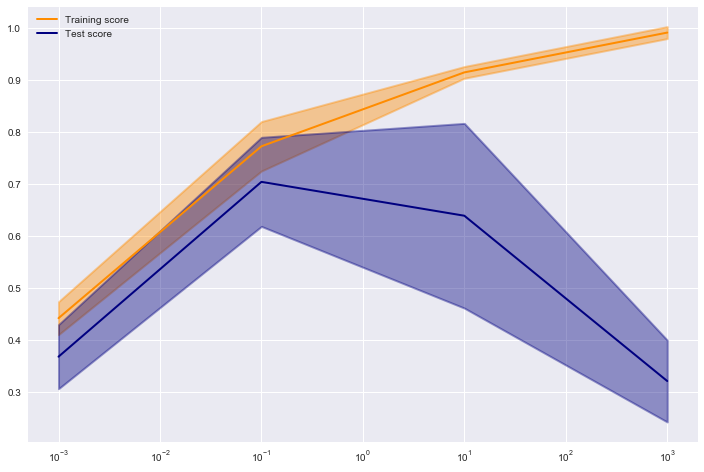

In [84]:
fig, ax = plt.subplots(figsize=(12,8))
ax.semilogx(gamma_range, train_mean, label='Training score', color='darkorange', lw=2)
ax.fill_between(gamma_range, train_mean-train_std, train_mean+train_std, color='darkorange', alpha=.4, lw=2)
ax.semilogx(gamma_range, test_mean, label='Test score', color='navy', lw=2)
ax.fill_between(gamma_range, test_mean-test_std, test_mean+test_std, color='navy', alpha=.4, lw=2)
ax.legend()

## Decision Trees

Train Score:  1.0
Test Score:  0.973684210526


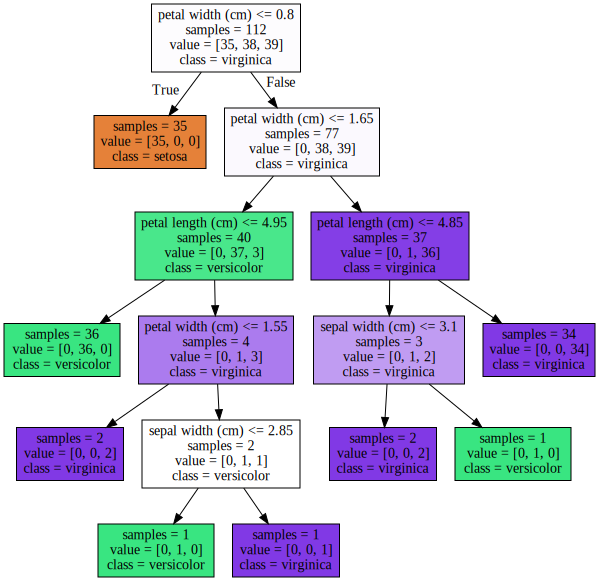

In [129]:
iris = sklearn.datasets.load_iris()
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(iris.data, iris.target, random_state=3)
clf = sklearn.tree.DecisionTreeClassifier().fit(X_train, y_train)
print('Train Score: ', clf.score(X_train, y_train))
print('Test Score: ', clf.score(X_test, y_test))
mlu.plot_decision_tree(clf, iris.feature_names, iris.target_names)


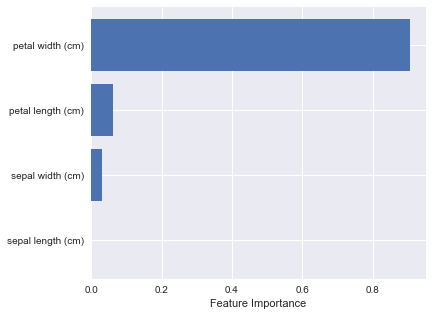

In [130]:
fig, ax = plt.subplots(figsize=(6,5))
mlu.plot_feature_importances(ax, clf, iris.feature_names)

#### max depth to avoid overfit

Train Score (Max_depth:3):  0.982142857143
Test Score (Max_depth:3):  0.973684210526


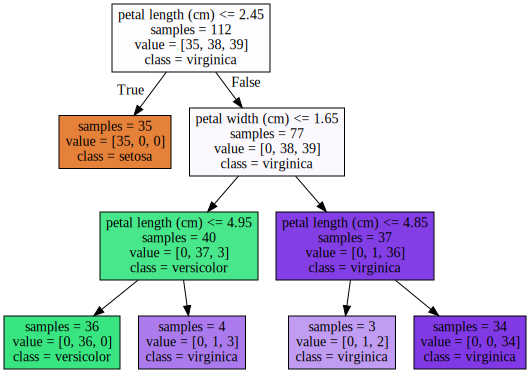

In [131]:
iris = sklearn.datasets.load_iris()
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(iris.data, iris.target, random_state=3)
clf = sklearn.tree.DecisionTreeClassifier(max_depth=3).fit(X_train, y_train)
print('Train Score (Max_depth:3): ', clf.score(X_train, y_train))
print('Test Score (Max_depth:3): ', clf.score(X_test, y_test))
mlu.plot_decision_tree(clf, iris.feature_names, iris.target_names)

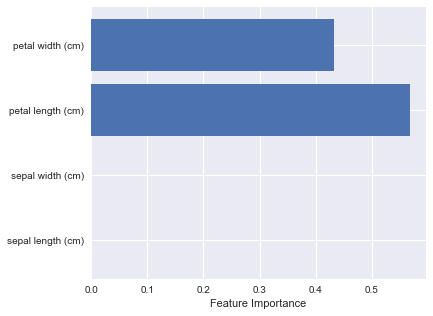

In [132]:
fig, ax = plt.subplots(figsize=(6,5))
mlu.plot_feature_importances(ax, clf, iris.feature_names)

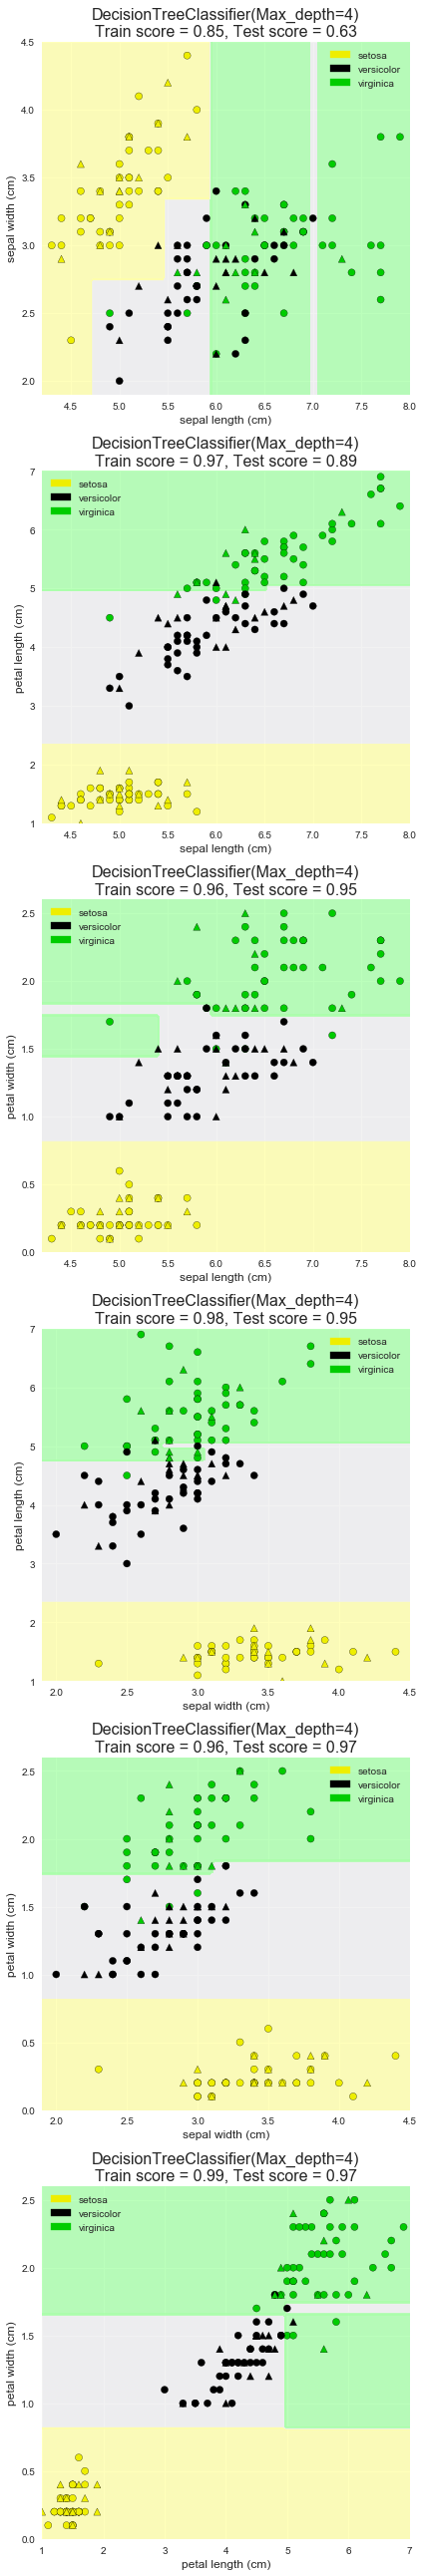

In [159]:
importlib.reload(mlutil)
mlu = mlutil.MLUtil()

pair_list = list(itertools.combinations(range(iris.data.shape[1]), 2))
fig, axs = plt.subplots(len(pair_list), 1, figsize=(6, len(pair_list)*6))

for pair, ax in zip(pair_list, axs):
    max_depth = 4
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(iris.data, iris.target, random_state=0)
    xy_labels = [iris.feature_names[i] for i in pair]
    mlu.plot_class_regions_for_classifier_subplot(sklearn.tree.DecisionTreeClassifier, {'max_depth':max_depth}, ax, X_train[:, pair], 
                                                  X_test[:, pair], y_train, y_test, xy_labels=xy_labels, target_names=iris.target_names)

plt.tight_layout()

#### Decisions trees on cancer data.

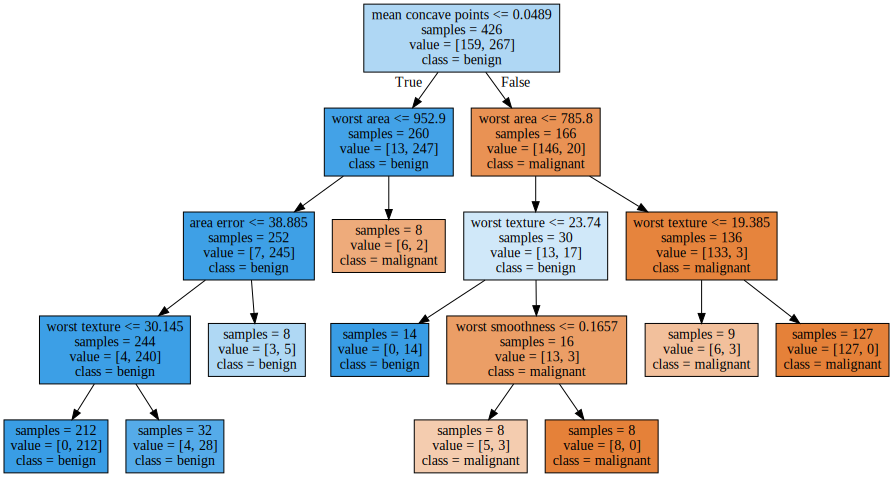

In [170]:
bc = sklearn.datasets.load_breast_cancer()
X, y = bc.data, bc.target
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=0)
clf = sklearn.tree.DecisionTreeClassifier(max_depth=4, min_samples_leaf=8, random_state=0).fit(X_train, y_train)
mlu.plot_decision_tree(clf, bc.feature_names, bc.target_names)

DT Train Score:  0.964788732394
DT Test Score:  0.937062937063


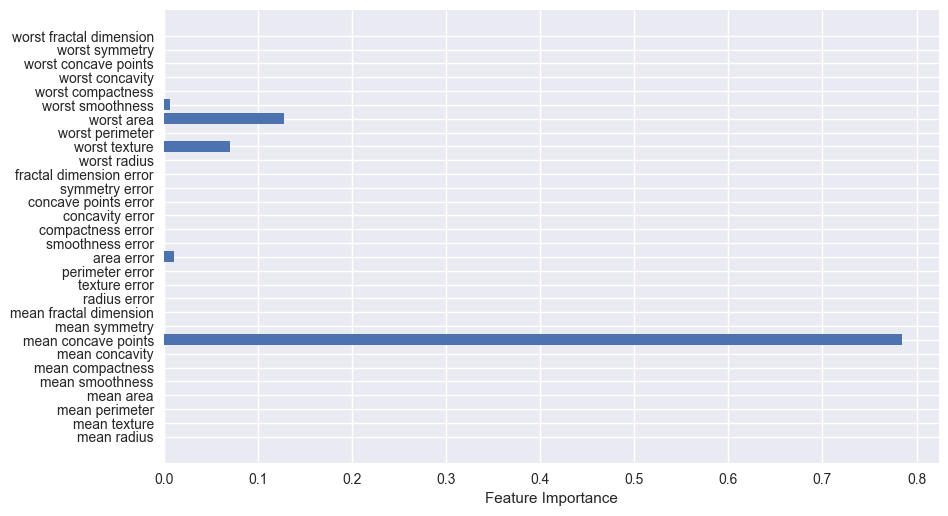

In [178]:
print('DT Train Score: ', clf.score(X_train, y_train))
print('DT Test Score: ', clf.score(X_test, y_test))
fig, ax = plt.subplots(figsize=(10,6), dpi=100)
mlu.plot_feature_importances(ax, clf, bc.feature_names)